# Improved filter

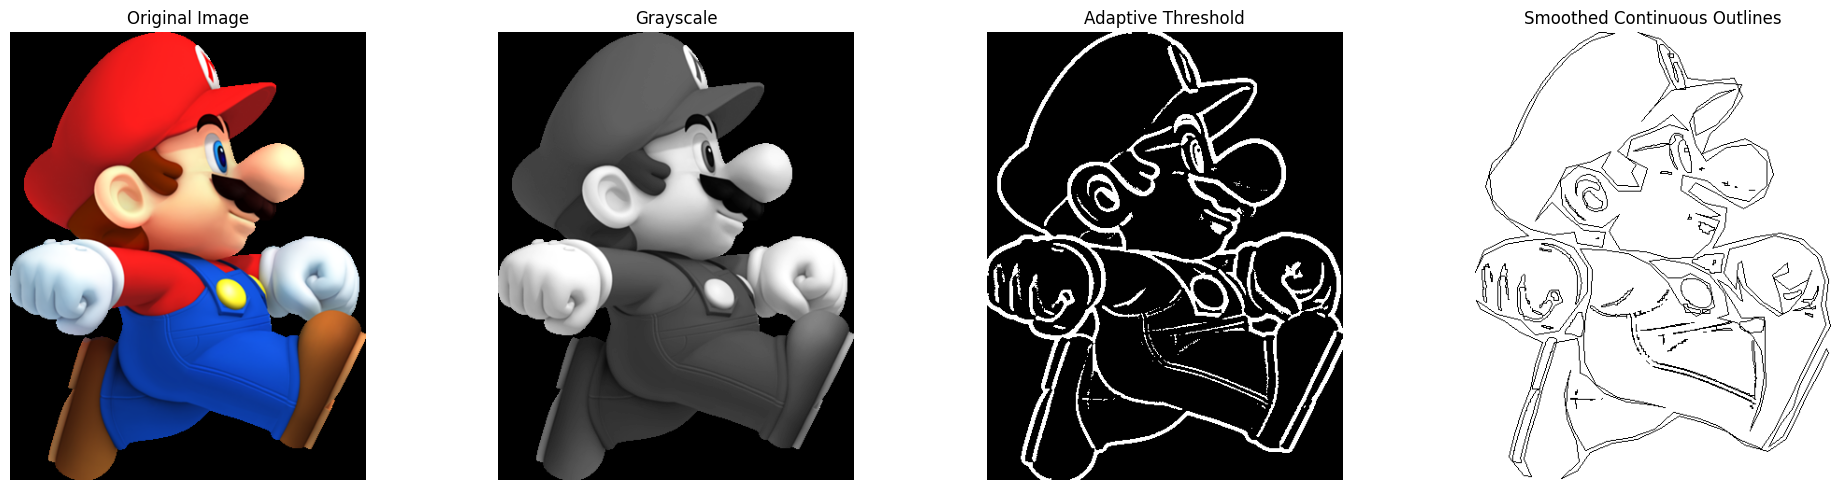

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
from scipy.interpolate import splprep, splev

# === STEP 1: Load and grayscale image ===
image = cv2.imread("mario.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# === STEP 2: Reduce noise ===
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# === STEP 3: Adaptive Thresholding (better for fine outlines) ===
binary = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 11, 2
)

# === STEP 4: Morphological Closing to Join Gaps ===
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# === STEP 5: Find Contours (external + internal) ===
contours, _ = cv2.findContours(closed, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# === STEP 6: Smooth contours using spline interpolation ===
def smooth_contour(contour, smoothing=0.01):
    contour = contour[:, 0, :]  # remove extra dim
    if len(contour) < 5:
        return contour  # too short to smooth
    x, y = contour[:, 0], contour[:, 1]
    x = np.r_[x, x[0]]
    y = np.r_[y, y[0]]
    tck, _ = splprep([x, y], s=len(contour) * smoothing, per=True)
    u_new = np.linspace(0, 1, 300)
    x_new, y_new = splev(u_new, tck)
    return np.stack([x_new, y_new], axis=1)

# === STEP 7: Create white canvas and draw smooth contours ===
smooth_canvas = np.ones_like(gray) * 255  # white background

for contour in contours:
    smooth = smooth_contour(contour)
    smooth = np.round(smooth).astype(int)
    for i in range(len(smooth) - 1):
        pt1 = tuple(smooth[i])
        pt2 = tuple(smooth[i + 1])
        cv2.line(smooth_canvas, pt1, pt2, color=0, thickness=1)

# === STEP 8: Export smooth contours to SVG ===
dwg = svgwrite.Drawing("girl.svg", profile="tiny", size=(image.shape[1], image.shape[0]))
for contour in contours:
    smooth = smooth_contour(contour)
    path_data = "M " + " L ".join(f"{int(x)},{int(y)}" for x, y in smooth) + " Z"
    dwg.add(dwg.path(d=path_data, stroke="black", fill="none", stroke_width=1))
dwg.save()

# === STEP 9: Display results ===
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(gray, cmap="gray")
ax[1].set_title("Grayscale")
ax[1].axis("off")

ax[2].imshow(binary, cmap="gray")
ax[2].set_title("Adaptive Threshold")
ax[2].axis("off")

ax[3].imshow(smooth_canvas, cmap="gray")
ax[3].set_title("Smoothed Continuous Outlines")
ax[3].axis("off")

plt.tight_layout()
plt.show()